#### Workshop Description
Understanding the questions posed by instructors and students alike plays an important role in the development of educational technology applications. In this intermediate level workshop, you will learn to apply NLP to one piece of this real-world problem by building a model to predict the type of answer (e.g. entity, description, number, etc.) a question elicits. Specifically, you will learn to:
1. Perform preprocessing, normalization, and exploratory analysis on a question dataset,
2. Identify salient linguistic features of natural language questions, and
3. Experiment with different feature sets and models to predict the answer type.
4. Use powerful pretrained language models to create dense sentence representations and apply deep learning models to text classification.

The concepts will be taught using popular NLP and ML packages like SpaCy, Scikit Learn, and Tensorflow.

This workshop assumes familiarity with Jupyter notebooks and the basics of scientific packages like numPy and sciPy. We also assume some basic knowledge of machine learning and deep learning techniques like CNNs, LSTMs, etc. Reference materials will be provided to gain a better understanding of these techniques for interested attendees.
***

# Exploratory Data Analysis
This notebook is the 1st of 3 for the Course Hero ODSC workshop "Applications of NLP in EdTech." In this notebook, we will 

1. Load train and test data into Pandas DataFrames
2. Process question text with a pretrained SpaCy English model
3. Observe and analyze the labels and question text in an effort to inform the next steps in the ML pipeline (namely, feature extraction and text classification).


_Step 3 above involves a number of steps, some of which are listed here for reference_:
- Plotting the frequency of coarse- and fine-grained labels 
- Observing sample questions from each coarse-grained class
- Finding and removing duplicate questions
- Plotting question length (both as word count and character count)
- Observing the most common starting words, and the overall most frequent words by label.
- Looking at Named Entities and how they are distributed across the coars-grained labels.

In [1]:
from typing import Tuple, List, Union
import matplotlib.pyplot as plt

get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

In [27]:
from download_data import main as download_trec_data
from os.path import exists, join
import pandas as pd
import spacy

#
# Initialize the SpaCy model.
#

nlp = spacy.load('en_core_web_md')


### Download Data

First let's download the train and test data from Xin Li, Dan Roth, Learning Question Classifiers. COLING'02, Aug., 2002.
    <https://cogcomp.seas.upenn.edu/Data/QA/QC/">https://cogcomp.seas.upenn.edu/Data/QA/QC/>
    
We will store these data in Pandas DataFrames (and write them as .csv files) containing the following columns:
- *question*: The question text
- *processed_question*: The question as a SpaCy Doc object
- *coarse_label*: The coarse-grained label (6 classes)
- *label*: The fine-grained label

In [28]:
if not exists("data"):
    train_df, test_df = download_trec_data()
else:
    path_to_train = join("data", "train.csv")
    path_to_test = join("data", "test.csv")

    train_df = pd.read_csv(join("data", "train.csv"))
    test_df = pd.read_csv(join("data", "test.csv"))

#
# Process questions with SpaCy
#
train_df['processed_question'] = train_df.question.apply(nlp)
test_df['processed_question'] = test_df.question.apply(nlp)


### Exploring Label Frequencies
Take a look at the "Coarse-Grained" (_coarse_label_) and "Fine-Grained" (_label_) labels to get an idea of how they are distributed in the training data.

Specifically, we will 
1. Group the DataFrame by coarse-grained/fine-grained label and aggregating with `.count()`.
2. Use `grouped_df.plot.barh()` to create a horizontal bar chart.

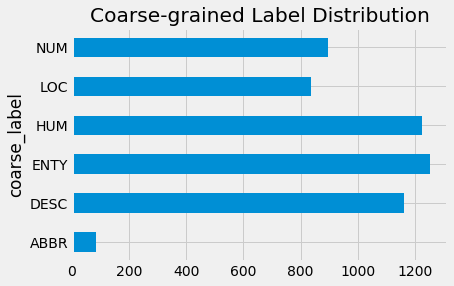

In [4]:
#
# Plot the frequencies
#
coarse_label_frequencies = train_df.groupby('coarse_label').count()['question'] 
_ = coarse_label_frequencies.plot.barh(title="Coarse-grained Label Distribution")

Generally, the coarse-grained labels are similarly-distributed, with one exception, **ABBR**. We will want to keep this in mind when we perform the modeling. Specifically, we should check that we have enough data to learn useful patterns for this underrepresented class.

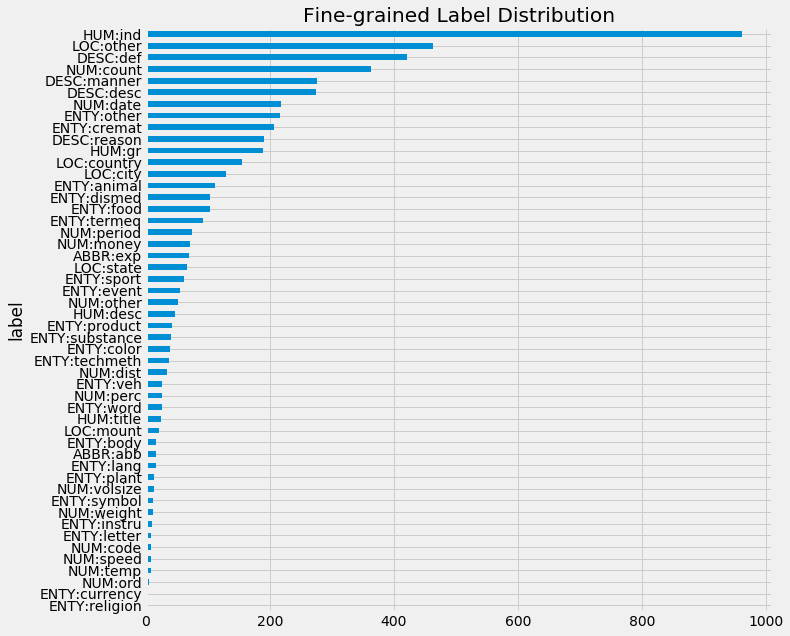

In [5]:
#
# Plot all of the fine-grained labels in a bar chart.
#
sorted_fine_grained_label_frequencies = train_df.groupby('label').count()['question'].sort_values()
_ = (sorted_fine_grained_label_frequencies
     .plot
     .barh(title="Fine-grained Label Distribution", figsize=(10,10)))

Unlike the coarse-grained label distribution, the fine-grained label distribution is quite skewed, with "HUM:ind" (human - individual) far more frequent than any other fine-grained label. We should keep this in mind if we want to tackle fine-grained question classification.

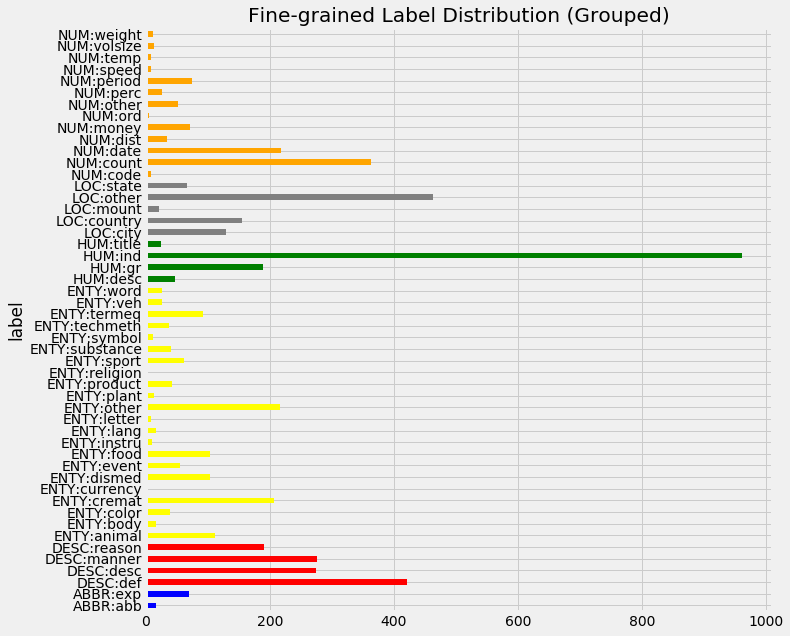

In [6]:
#
# Create a bar chart of the fine-grained labels, color-coding the coarse-grained groups.
#

colors = ['red', 'yellow', 'blue', 'green', 'orange', 'gray']

coarse_label_color_map = {label:colors[i] for i, label in enumerate(train_df.coarse_label.unique())}
fine_label_colors = []
for l in sorted(train_df.label.unique()):
    fine_label_colors.append(coarse_label_color_map[l.split(':')[0]])

    
fine_grained_label_frequencies = train_df.groupby('label').count()['question']
_ = (fine_grained_label_frequencies
     .plot
     .barh(title="Fine-grained Label Distribution (Grouped)", 
           figsize=(10,10), 
           color=fine_label_colors))

This plot helps make a bit more sense of the distribution skew in fine-grained labels. Even though HUM:ind is far more frequent than the rest, its coarse-grained class has a small number of fine-grained labels when compared to the rest of the coarse-grained labels (ENTY, for example, is spread across 22 fine-grained labels vs 3 for HUM).

### Explore the Questions!
Let's take a look at some of the question texts by sampling a few questions per coarse-grained label, using `df.sample(n)`.

In [7]:
import random

def sample_questions(coarse_label, n=10):
    question_sample = (train_df[train_df['coarse_label'] == coarse_label]
                       .sample(n).question)
    print("\n".join(question_sample))

In [8]:
#
# Human
#
sample_questions('HUM')

What TV comedian worked with White Fang , Black Tooth and Pookie the Lion ?
What 's Japan 's largest car manufacturer ?
What TV character said ; `` One of these days , Alice , pow , right in the kisser '' ?
Which Bloom County resident wreaks havoc with a computer ?
Who was the lawyer for Randy Steven Craft ?
Who is John Macarthur , 1767-1834 ?
Whose image is alleged to be on The Shroud of Turin ?
What comedian created a punch-drunk pugilist named Cauliflower McPugg ?
Who was The Pride of the Yankees ?
Who was the Russian ambassador to Hungary during the 1956 uprising ?


---
_Some things to notice about HUM_
- _many of the HUM questions start with 'Who'._
- _this suggests that the specific question word in the sentence may offer some indication of its label_
---

In [9]:
#
# Location
#
sample_questions('LOC')

What desert country borders Saudi Arabia , Iraq and the Persian Gulf ?
What country is the origin of the band the Creeps ?
What two countries are separated by the Bering Strait ?
What canal does the Thatcher Ferry Bridge span ?
What are the names of the tourist attractions in Reims ?
What country borders Denmark to the south ?
What gate opened on East and West Berlin ?
In what city does Maurizio Pellegrin now live ?
What are the world 's four oceans ?
What 's the world 's largest cathedral ?


---
_Some things to notice about LOC_
- _prevalence of place names_
---

In [10]:
#
# Abbreviation
#
sample_questions('ABBR')

What does BMW stand for ?
What is the abbreviation for micro ?
What does MSG stand for ?
What does pH stand for ?
What is the abbreviated term used for the National Bureau of Investigation ?
What does JESSICA mean ?
What does R.E.M. stand for , as in the rock group R.E.M. ?
What is a `` USB '' port on a computer ?
What does e.g. stand for ?
What 's the abbreviation for trinitrotoluene ?


---
_Some things to notice about ABBR_
- _these questions mostly tend to follow simple templates_
- _"What is [A-Z]+?", "What does __ stand for?"_
---


#### Duplicates
Check for duplicates. If there are any, let's remove them.

- To get the duplicates, group by question text and filter out groups that only have one member (those are unique questions).
- For removing duplicates, Pandas Dataframes have a really useful `.drop_duplicates()` [method!](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

In [11]:
#
# Count how many questions are duplicated
#
question_counts = train_df.groupby('question').count()[['label']]
question_counts.columns = ['count']
duplicate_questions = question_counts[question_counts['count'] > 1]
print("Number of duplicates:", len(duplicate_questions))
duplicate_questions.sample(5)

Number of duplicates: 63


,count
question,
What was the first minimum wage ?,2
How deep is a fathom ?,3
How many meters are in a mile ?,2
What chapter of the Bible has the most verses ?,2
What fraction of a beaver 's life is spent swimming ?,2


In [12]:
#
# Remove duplicate questions
#
print("Length before dropping duplicates:", len(train_df))
train_df = train_df.drop_duplicates("question")
print("Length after dropping duplicates:", len(train_df))

Length before dropping duplicates: 5452
Length after dropping duplicates: 5381


### Do the questions look as we expect them to?


**_How long are the questions? (number of characters and number of words)_**

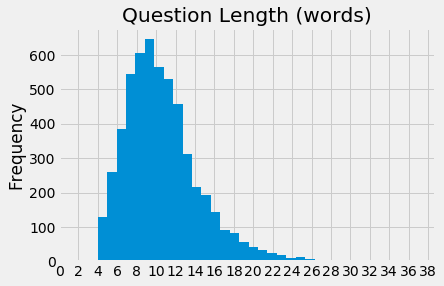

In [13]:
question_lengths_words = train_df.processed_question.apply(len)
_ = question_lengths_words.plot.hist(title="Question Length (words)", bins=35, xticks=range(0, 40, 2))


In [14]:
#
# Take a look at some of the questions with the fewest number of words.
#
sorted(list(train_df.processed_question), key=lambda q: len(q))[:10]

[Define cosmology .,
 Who shoplifts ?,
 How was Lawrence,
 Define Spumante .,
 Who killed Gandhi ?,
 What is ethology ?,
 What is titanium ?,
 What is gymnophobia ?,
 Who produces Spumante ?,
 Who discovered electricity ?]

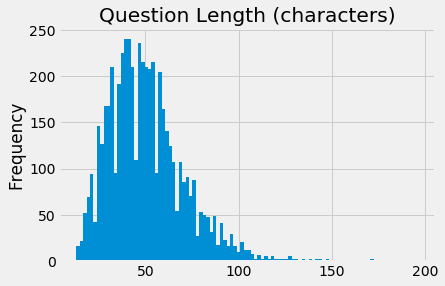

In [15]:
question_lengths_chars = train_df.question.apply(len)
_ = question_lengths_chars.plot.hist(title="Question Length (characters)", bins=100)


In [16]:
#
# Take a look at some of the questions with the fewest characters.
#
sorted(list(train_df.question), key=lambda q: len(q))[:10]

['What is BPH ?',
 'What is Plc ?',
 'What is God ?',
 'What is RCD ?',
 'What is AFS ?',
 'What is SAP ?',
 'What is DSL ?',
 'What is HTML ?',
 'What is Java ?',
 'What is DEET ?']

---

See how most of these are abbreviations? Maybe 'number of characters' will make a useful feature in our predictive model!

---

#### Are there any questions that don't have a question mark?

In [17]:
#
# How many of the questions end in question marks?
#
def ends_with_qmark(q: spacy.tokens.doc.Doc):
    return q[-1].text == '?'

print("Number of questions ending in '?': {} out of {}"
      .format(len(train_df[train_df['processed_question'].apply(ends_with_qmark)]), len(train_df)))
print("\n")
#
# And of those that don't, what do they look like?
#
print("\n".join(train_df[train_df['processed_question'].apply(lambda q: not ends_with_qmark(q))].question.sample(10)))

Number of questions ending in '?': 5254 out of 5381


What country did the Nazis occupy for 1 , CD NNS IN NNP NNP NNP .
What 's the meaning of the Latin battle cry : Ad arma , ad arma .
Name one of the major gods of Hinduism .
What poem contains the line , `` grow old with me the best is yet to be '' .
Who murdered Leno and Rosemary LaBianca on August 1
How did U.S.A become involved in the Barbary Wars
How many times more than 3
How tall was the animated Frankenstein
Name Li 'l Abner 's favorite Indian drink .
Who said : `` What contemptible scoundrel stole the cork from my lunch ? ''


#### What about questions with more than one question mark? 

In [18]:
#
# Are there any questions that mave multiple sentences or multiple question marks?
#
def has_multiple_qmarks(q):
    return len([ch for ch in q if ch == '?']) > 1

print("Number of questions with multiple question marks:", 
      len(train_df[train_df['question'].apply(has_multiple_qmarks)]))
print("\n")
print("\n".join(train_df[train_df['question'].apply(has_multiple_qmarks)].question))

Number of questions with multiple question marks: 7


Who graced the airwaves with such pearls as `` Do ya lo-o-ove me ? Get naked , baby ! '' ?
Who was named Admiral of the Ocean Seas and Viceroy and Governor General of all the islands he might discover , and also granted 10-?? of all profits of his voyage .
Why do people in the upper peninsula of Michagin say `` eh ? '' ?
How do you exterminate bees that are in the walls of your home ? Will bee eggs remain over winter ?
How many URL extensions are there ? and what are they ?
How many `` No '' answers was the What 's My Line ? panel allowed ?
Why are there letters on the telephone ? Why are there no Q or Z ?





## What are the most common starting words?

- Extract the first word from each question (use the `processed_question` column for tokenized questions), and count their frequencies.

- Also, try counting unique word+part-of-speech tuples to see in what ways these words are used at the beginning of the questions.


What		3190
How		753
Who		556
Where		271
When		131
Which		104
Why		103
Name		88
In		66
The		18
Whose		14
On		13
CNN		5
Define		4
Whom		4
For		3
Aspartame		3
Rotary		3
Colin		3
To		2
--------------------------------------------------
What//WP		2255
What//WDT		935
How//WRB		753
Who//WP		556
Where//WRB		271
When//WRB		131
Which//WDT		104
Why//WRB		103
Name//VB		73
In//IN		66
The//DT		18
Whose//JJ		14
On//IN		13
Name//NN		10
Name//NNP		5
CNN//NNP		5
Whom//WP		4
For//IN		3
Aspartame//NN		3
Rotary//JJ		3


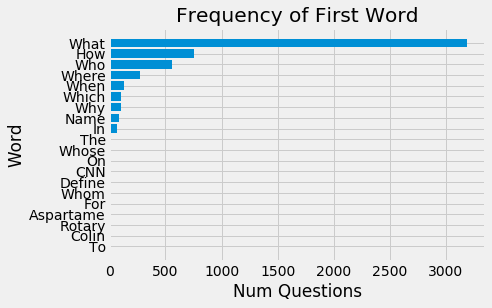

In [19]:
from collections import Counter

#
# Get the raw list of words, and word//part-of-speech.
#
starting_words = train_df.processed_question.apply(lambda q: q[0].text)
starting_words_pos = train_df.processed_question.apply(lambda q: "{}//{}".format(q[0].text, q[0].tag_))

#
# Only keep the top 20.
#
words, counts = zip(*sorted(Counter(starting_words).items(), 
                            key=lambda t: t[1], 
                            reverse=True)[:20])
words_w_pos, counts_w_pos = zip(*sorted(Counter(starting_words_pos).items(), 
                            key=lambda t: t[1], 
                            reverse=True)[:20])

#
# Print the 20 most frequent
#
print("\n".join(["{}\t\t{}".format(words[i], counts[i]) for i in range(len(words))]))
print("-" * 50)
print("\n".join(["{}\t\t{}".format(words_w_pos[i], counts_w_pos[i]) for i in range(len(words))]))


#
# Plot the starting word frequencies
#
plt.barh(words[::-1], counts[::-1])
plt.title("Frequency of First Word")
plt.ylabel("Word")
plt.xlabel("Num Questions")
plt.show()

### Word Frequency Cloud 
- Let's use the [Wordcloud](https://github.com/amueller/word_cloud) package to visualize the word frequencies for the different coarse-grained labels. 
- By default, Wordcloud removes words that are on its "stopwords" list. To avoid removing these common, often functional lexical items, specify `stopwords=[]` when calling `WordCloud()`.
- Try plotting the words with, and later without stopwords and observe the differences. What advantages there in removing the stop words as a preprocessing step? Disadvantages?

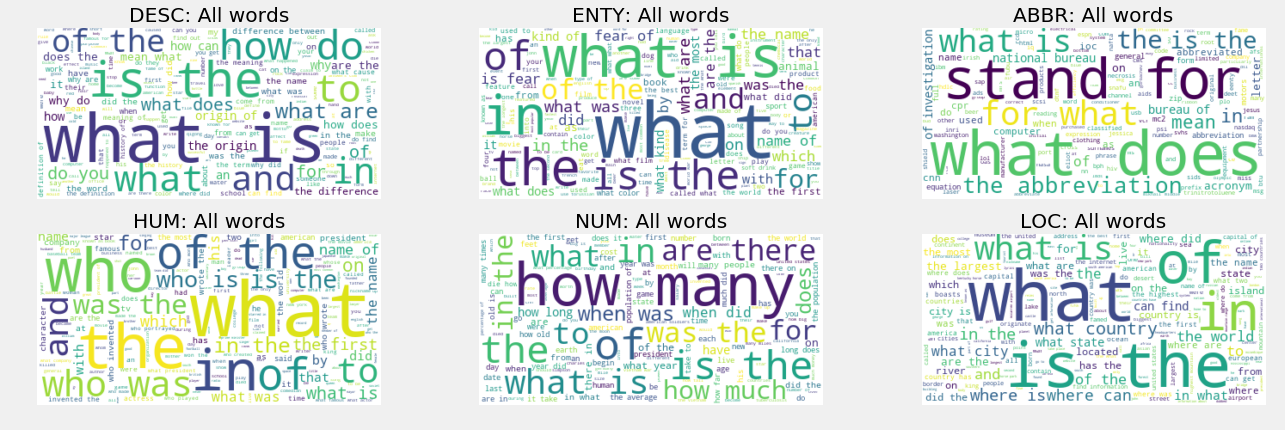

In [20]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 10))
columns = 3
unique_labels = train_df.coarse_label.unique()
for i, label in enumerate(unique_labels):
    text = "\n".join(list(train_df[train_df['coarse_label'] == label].question)).lower()
    wordcloud = WordCloud(background_color='white', stopwords=[]).generate(text)
    ax = plt.subplot(len(unique_labels) / columns + 1, columns, i + 1)
    plt.title("{}: All words".format(label))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')


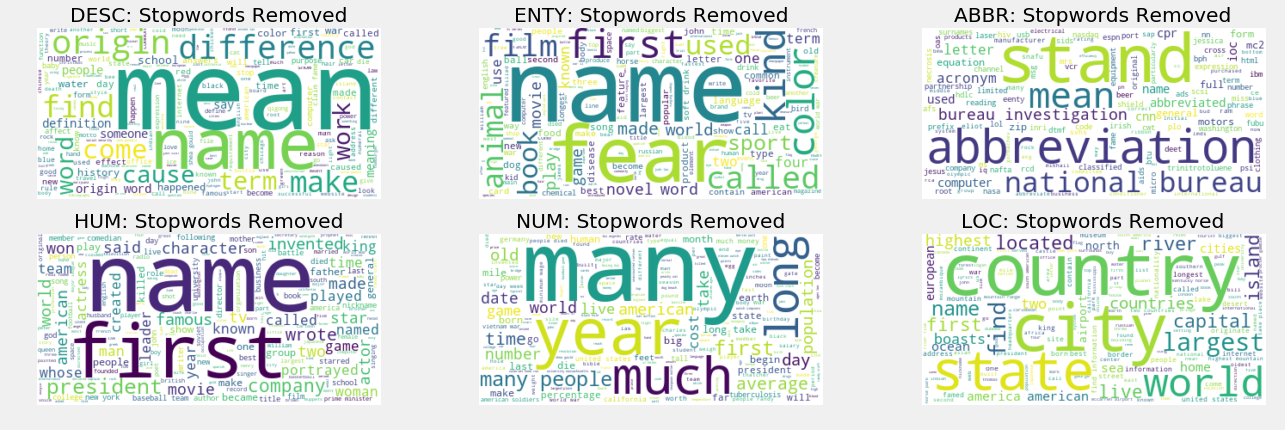

In [21]:
#
# Excluding stopwords...
#

plt.figure(figsize=(20, 10))
columns = 3

for i, label in enumerate(unique_labels):
    text = "\n".join(list(train_df[train_df['coarse_label'] == label].question)).lower()
    wordcloud = WordCloud(background_color='white').generate(text)
    ax = plt.subplot(len(unique_labels) / columns + 1, columns, i + 1)
    plt.title("{}: Stopwords Removed".format(label))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')

### Let's explore patterns of capitalization in the data

In a lot of NLP work, the standard has always been to lowercase all text during text normalization. But, often capitalization can be quite informative. Let's see if this is the case here. </div>



Here, SpaCy provides us with tokenized text, and each token has attributes like `.is_title` is the firs letter is capitalized, and `.is_upper` if the whole word is capitalized.

In [22]:
doc = nlp("This is a TEST")
print("first token is title-cased: {}".format(doc[0].is_title))
print("last token is upper: {}".format(doc[-1].is_upper))

first token is title-cased: True
last token is upper: True


In [23]:
#
# Count the frequency of words with the first letter capitalized and show the top 50
#
title_words = [word.text for question in train_df.processed_question for word in question if word.is_title]
title_word_counts = sorted(Counter(title_words).items(), key=lambda t: t[1], reverse=True)[:50]
print("\n".join(["{}\t{}".format(w, c) for w, c in title_word_counts]))


What	3194
How	753
Who	558
Where	273
I	209
The	161
U.S.	134
When	132
Why	104
Which	104
Name	89
American	76
In	68
New	48
War	46
World	45
President	45
John	40
America	35
English	32
South	32
United	28
States	24
California	24
York	24
King	22
A	20
North	20
West	19
Day	19
French	19
Charles	19
Internet	18
Russian	18
Randy	17
Craft	17
Earth	16
British	16
Kennedy	16
London	16
San	16
National	16
Nixon	16
Germany	16
Great	15
Japanese	15
George	15
James	15
Spanish	15
England	15


In [24]:
#
# Count the frequency of words with all letters capitalized (title case) 
# and show the 50 most frequent.
#
title_words = [word.text for question in train_df.processed_question for word in question if word.is_upper]
title_word_counts = sorted(Counter(title_words).items(), key=lambda t: t[1], reverse=True)[:25]
print("\n".join(["{}\t{}".format(w, c) for w, c in title_word_counts]))

I	209
U.S.	134
TV	51
A	20
US	18
II	17
NN	15
CNN	12
F.	12
O	8
AIDS	7
NNP	7
E	7
DC	6
VHS	6
D.C.	6
USA	6
NFL	6
IBM	5
D.	5
CD	4
K	4
DT	4
J.	4
L.A.	4


### Named Entity Types 

What are the frequencies of different Named Entity types in the data? And how are they distributed across the coarse-grained labels?


We can leverage SpaCy's prebuilt English model to find the NEs:</div>
```
>>> token.ent_type_
```

In [25]:
#
# Count the frequency of 
#
title_words = [word.ent_type_ for question in train_df.processed_question for word in question if word.ent_type_]
title_word_counts = sorted(Counter(title_words).items(), key=lambda t: t[1], reverse=True)[:25]
print("\n".join(["{}\t{}".format(w, c) for w, c in title_word_counts]))

PERSON	2410
ORG	1440
GPE	1163
DATE	855
WORK_OF_ART	786
NORP	444
LOC	433
CARDINAL	414
EVENT	311
FAC	250
ORDINAL	206
QUANTITY	119
PRODUCT	105
LAW	72
TIME	46
MONEY	37
LANGUAGE	36
PERCENT	15


In [26]:
all_ne_types = []
coarse_labels = list(train_df.coarse_label.unique())
for label in coarse_labels:
    print(label)
    print("-" * 50)
    questions = train_df[train_df['coarse_label'] == label].processed_question
    ne_types = []
    for question in questions:
        ne_types += list({w.ent_type_ for w in question if w.ent_type_})
    ne_types = [word.ent_type_ for question in questions for word in question if word.ent_type_]
    freq_counts = Counter(ne_types)
    
    total = sum(freq_counts.values())
    freq_counts = {k: round(100*v/total, 0) for k, v in freq_counts.items()}
    
    ne_type_counts = sorted(freq_counts.items(), key=lambda t: t[1], reverse=True)
    all_ne_types.append(ne_type_counts)
    print("\n".join(["{}\t{}".format(w, c) for w, c in ne_type_counts]))
    print("\n\n")

DESC
--------------------------------------------------
PERSON	24.0
ORG	20.0
GPE	10.0
DATE	9.0
WORK_OF_ART	9.0
NORP	5.0
LAW	3.0
LOC	3.0
FAC	3.0
PRODUCT	3.0
CARDINAL	3.0
EVENT	2.0
MONEY	1.0
ORDINAL	1.0
TIME	1.0
QUANTITY	1.0
LANGUAGE	0.0
PERCENT	0.0



ENTY
--------------------------------------------------
PERSON	33.0
ORG	14.0
DATE	10.0
GPE	9.0
CARDINAL	7.0
WORK_OF_ART	7.0
NORP	5.0
EVENT	3.0
ORDINAL	3.0
LOC	2.0
PRODUCT	1.0
LANGUAGE	1.0
QUANTITY	1.0
FAC	1.0
MONEY	1.0
TIME	1.0
LAW	0.0
PERCENT	0.0



ABBR
--------------------------------------------------
ORG	72.0
PERSON	14.0
GPE	9.0
TIME	3.0
NORP	1.0
WORK_OF_ART	1.0



HUM
--------------------------------------------------
PERSON	32.0
ORG	16.0
WORK_OF_ART	14.0
GPE	10.0
DATE	8.0
CARDINAL	4.0
NORP	4.0
LOC	3.0
EVENT	3.0
ORDINAL	3.0
FAC	1.0
PRODUCT	1.0
QUANTITY	1.0
LANGUAGE	0.0
MONEY	0.0
TIME	0.0
LAW	0.0
PERCENT	0.0



NUM
--------------------------------------------------
PERSON	21.0
DATE	19.0
GPE	16.0
ORG	13.0
EVENT	6.0
LOC	4.0
WORK_OF_ART	

#### Final Thoughts
In this notebook, we covered a number of important steps you can take to get a better understanding of a text data set. 

There is, of course, much more that can be done to truly get a good understanding of all of the nature and nuances of the TREC question classification data.

---

Below are some references for those who would like to learn more about what was covered (and not) in this notebook:

- [Visualization in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

- [EDA and NLP video](https://www.youtube.com/watch?v=VraAbgAoYSk)

- A discussion of where you probably shouldn't use word clouds <https://www.niemanlab.org/2011/10/word-clouds-considered-harmful/>